In [1]:
import numpy as np
import os,random,shutil
np.random.seed(7)

In [2]:
# 1, 准备数据集
#1，指定一些超参数：
train_data_dir='E:\PyProjects\DataSet\DogsVsCats_Tiny/train'
val_data_dir='E:\PyProjects\DataSet\DogsVsCats_Tiny/test' # keras中将测试集称为validation set
train_samples_num=2000 # train set中全部照片数
val_samples_num=800
IMG_W,IMG_H,IMG_CH=150,150,3 # 单张图片的大小
batch_size=16 # 不能是32，因为2000/32不能整除，后面会有影响。
epochs=20  # 用比较少的epochs数目做演示，节约训练时间

In [5]:
# 此处的训练集和测试集并不是原始图片的train set和test set，而是用VGG16对图片提取的特征，这些特征组成新的train set和test set
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255) # 不需图片增强

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet') 
    # 使用imagenet的weights作为VGG16的初始weights,由于只是特征提取，故而只取前面的卷积层而不需要DenseLayer，故而include_top=False

    generator = datagen.flow_from_directory( # 产生train set
        train_data_dir,
        target_size=(IMG_W, IMG_H),
        batch_size=batch_size,
        class_mode=None, 
        shuffle=False) # 必须为False，否则顺序打乱之后，和后面的label对应不上。
    bottleneck_features_train = model.predict_generator(
        generator, train_samples_num // batch_size) # 如果是32，这个除法得到的是62，抛弃了小数，故而得到1984个sample
    np.save('E:\PyProjects\DataSet\FireAI\DeepLearning\FireAI006/bottleneck_features_train.npy', bottleneck_features_train)
    print('bottleneck features of train set is saved.')

    generator = datagen.flow_from_directory(
        val_data_dir,
        target_size=(IMG_W, IMG_H),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, val_samples_num // batch_size)
    np.save('E:\PyProjects\DataSet\FireAI\DeepLearning\FireAI006/bottleneck_features_val.npy',bottleneck_features_validation)
    print('bottleneck features of test set is saved.')

In [6]:
save_bottlebeck_features()

Found 2000 images belonging to 2 classes.
bottleneck features of train set is saved.
Found 800 images belonging to 2 classes.
bottleneck features of test set is saved.


In [12]:
def my_model():
    '''
    自定义一个模型，该模型仅仅相当于一个分类器，只包含有全连接层，对提取的特征进行分类即可
    :return:
    '''
    # 模型的结构
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:])) # 将所有data进行flatten
    model.add(Dense(256, activation='relu')) # 256个全连接单元
    model.add(Dropout(0.5)) # dropout正则
    model.add(Dense(1, activation='sigmoid')) # 此处定义的模型只有后面的全连接层，由于是本项目特殊的，故而需要自定义

    # 模型的配置
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy']) # model的optimizer等

    return model

In [13]:
# 只需要训练分类器模型即可，不需要训练特征提取器
train_data = np.load('E:\PyProjects\DataSet\FireAI\DeepLearning\FireAI006/bottleneck_features_train.npy') # 加载训练图片集的所有图片的VGG16-notop特征
train_labels = np.array(
    [0] * int((train_samples_num / 2)) + [1] * int((train_samples_num / 2)))
# label是1000个cat，1000个dog，由于此处VGG16特征提取时是按照顺序，故而[0]表示cat，1表示dog

validation_data = np.load('E:\PyProjects\DataSet\FireAI\DeepLearning\FireAI006/bottleneck_features_val.npy')
validation_labels = np.array(
    [0] * int((val_samples_num / 2)) + [1] * int((val_samples_num / 2)))

# 构建分类器模型
clf_model=my_model()
history_ft = clf_model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))

Train on 2000 samples, validate on 800 samples
Epoch 1/20
2000/2000 [==============================] - 6s 3ms/step - loss: 0.8426 - acc: 0.7455 - val_loss: 0.4280 - val_acc: 0.8063
Epoch 2/20
2000/2000 [==============================] - 5s 3ms/step - loss: 0.3928 - acc: 0.8365 - val_loss: 0.3078 - val_acc: 0.8675
Epoch 3/20
2000/2000 [==============================] - 5s 3ms/step - loss: 0.3144 - acc: 0.8720 - val_loss: 0.4106 - val_acc: 0.8588
Epoch 4/20
2000/2000 [==============================] - 5s 3ms/step - loss: 0.3032 - acc: 0.8830 - val_loss: 0.3058 - val_acc: 0.8850
Epoch 5/20
2000/2000 [==============================] - 5s 3ms/step - loss: 0.2446 - acc: 0.9050 - val_loss: 0.3050 - val_acc: 0.8962
Epoch 6/20
2000/2000 [==============================] - 5s 3ms/step - loss: 0.2199 - acc: 0.9120 - val_loss: 0.3157 - val_acc: 0.8975
Epoch 7/20
2000/2000 [==============================] - 5s 3ms/step - loss: 0.2057 - acc: 0.9225 - val_loss: 0.3591 - val_acc: 0.8812
Epoch 8/20
2000

In [14]:
# 画图，将训练时的acc和loss都绘制到图上
import matplotlib.pyplot as plt
%matplotlib inline
def plot_training(history):
    plt.figure(12)
    
    plt.subplot(121)
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(len(train_acc))
    plt.plot(epochs, train_acc, 'b',label='train_acc')
    plt.plot(epochs, val_acc, 'r',label='test_acc')
    plt.title('Train and Test accuracy')
    plt.legend()
    
    plt.subplot(122)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(train_loss))
    plt.plot(epochs, train_loss, 'b',label='train_loss')
    plt.plot(epochs, val_loss, 'r',label='test_loss')
    plt.title('Train and Test loss')
    plt.legend()
 
    plt.show()

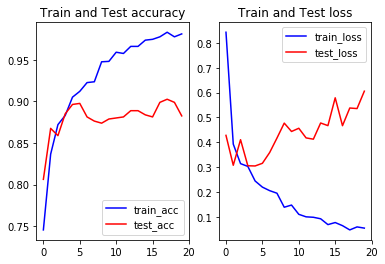

In [15]:
plot_training(history_ft)

In [16]:
# 将本模型保存一下
clf_model.save_weights('E:\PyProjects\DataSet\FireAI\DeepLearning\FireAI006/top_FC_model')